# Assignment 3 Part 2
## Diffusion Model

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# For Google Colab, commented out since running locally
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/A3_PartB/  #Use correct path
# !pwd

In [3]:
# Verify the AFHQ dataset is present
import os

data_path = './data/train'
if os.path.exists(data_path):
    print("✅ Dataset found!")
    print(f"📁 Data structure:")
    for category in ['cat', 'dog', 'wild']:
        cat_path = os.path.join(data_path, category)
        if os.path.exists(cat_path):
            num_images = len([f for f in os.listdir(cat_path) if f.endswith(('.jpg', '.png'))])
            print(f"   - {category}: {num_images} images")
else:
    print("❌ Dataset not found at ./data/train")
    print("Please download the AFHQ dataset manually and place it in the ./data folder")

✅ Dataset found!
📁 Data structure:
   - cat: 5065 images
   - dog: 4678 images
   - wild: 4593 images


In [4]:
# # Download the dataset afhq_v2.zip (6.48G)
# !mkdir -p ./data
# !gdown --id 1-1npXlqCw1CYQ5SBbrlSgZdA9TEwZre4 -O ./data/afhq_v2.zip #Using gdown to get the data from Google Drive location
# !unzip -q ./data/afhq_v2.zip -d ./data

In [5]:
# # Download the dataset afhq_v2.zip (6.48G) - OR use the one provided in the data folder
# !mkdir -p /content/data
# !wget -N https://www.dropbox.com/s/vkzjokiwof5h8w6/afhq_v2.zip?dl=0 -O /content/data/afhq_v2.zip
# !unzip -q /content/data/afhq_v2.zip -d /content/data

In [6]:
# # Set up the environment
# !pip install -r requirements.txt

In [18]:
# PART 1: (100 steps, ~10-15 minutes)
import subprocess
import sys
import os

# os.environ['WANDB_MODE'] = 'disabled'

process = subprocess.Popen(
    [sys.executable, 'main.py',
     '--data_path', './data/train',
     '--save_folder', './test_run',
     '--time_steps', '2',
     '--train_steps', '100',
     '--image_size', '32',
     '--batch_size', '32',
     '--learning_rate', '1e-3',
     '--unet_dim', '16',
     '--save_and_sample_every', '100'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1,
    encoding='utf-8',  # Add UTF-8 encoding
    errors='replace'   # Replace unknown characters with blank
)

# Stream output line by line in real-time
for line in iter(process.stdout.readline, ''):
    if line:
        print(line, end='', flush=True)

return_code = process.wait()

if return_code == 0:
    print("\n Test completed successfully!")
else:
    print(f"\n Test failed with error code: {return_code}")

Namespace(time_steps=2, train_steps=100, save_folder='./test_run', data_path='./data/train', load_path=None, data_class='cat', image_size=32, batch_size=32, learning_rate=0.001, unet_dim=16, unet_dim_mults=[1, 2, 4, 8], fid=False, save_and_sample_every=100, visualize=False)
dataset length: 5065, dataset class: cat

steps: 100%|██████████| 100/100 [00:55<00:00,  1.81it/s]
training completed

 Test completed successfully!


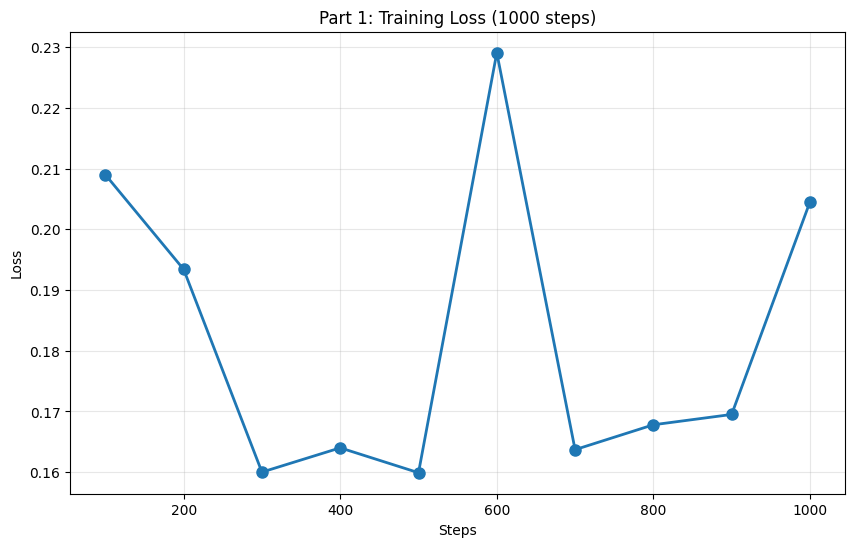

✅ Plot saved: ./test_run/part1_training_loss.png


In [17]:
# Part 1: Simple Training Loss Plot
import matplotlib.pyplot as plt

steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
losses = [0.2090, 0.1934, 0.1600, 0.1640, 0.1599, 0.2291, 0.1637, 0.1678, 0.1695, 0.2045]

plt.figure(figsize=(10, 6))
plt.plot(steps, losses, 'o-', linewidth=2, markersize=8)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Part 1: Training Loss (1000 steps)')
plt.grid(True, alpha=0.3)
plt.savefig('./test_run/part1_training_loss.png', dpi=300)
plt.show()
print("✅ Plot saved: ./test_run/part1_training_loss.png")

In [2]:
# Quick test Visualize the forward and backward diffusion process
import os

os.environ['WANDB_MODE'] = 'disabled'

!python main.py --data_path ./data/train/ --load_path ./test_run/model.pt --save_folder ./test_run --time_steps 50 --image_size 32 --batch_size 32 --learning_rate 1e-3 --unet_dim 16 --visualize

Namespace(time_steps=50, train_steps=50000, save_folder='./test_run', data_path='./data/train/', load_path='./test_run/model.pt', data_class='cat', image_size=32, batch_size=32, learning_rate=0.001, unet_dim=16, unet_dim_mults=[1, 2, 4, 8], fid=False, save_and_sample_every=1000, visualize=True)
dataset length: 5065, dataset class: cat
Loading :  ./test_run/model.pt
✅ Forward and backward diffusion images generated (wandb disabled)
   Forward diffusion: 5 images
   Backward diffusion: 5 images


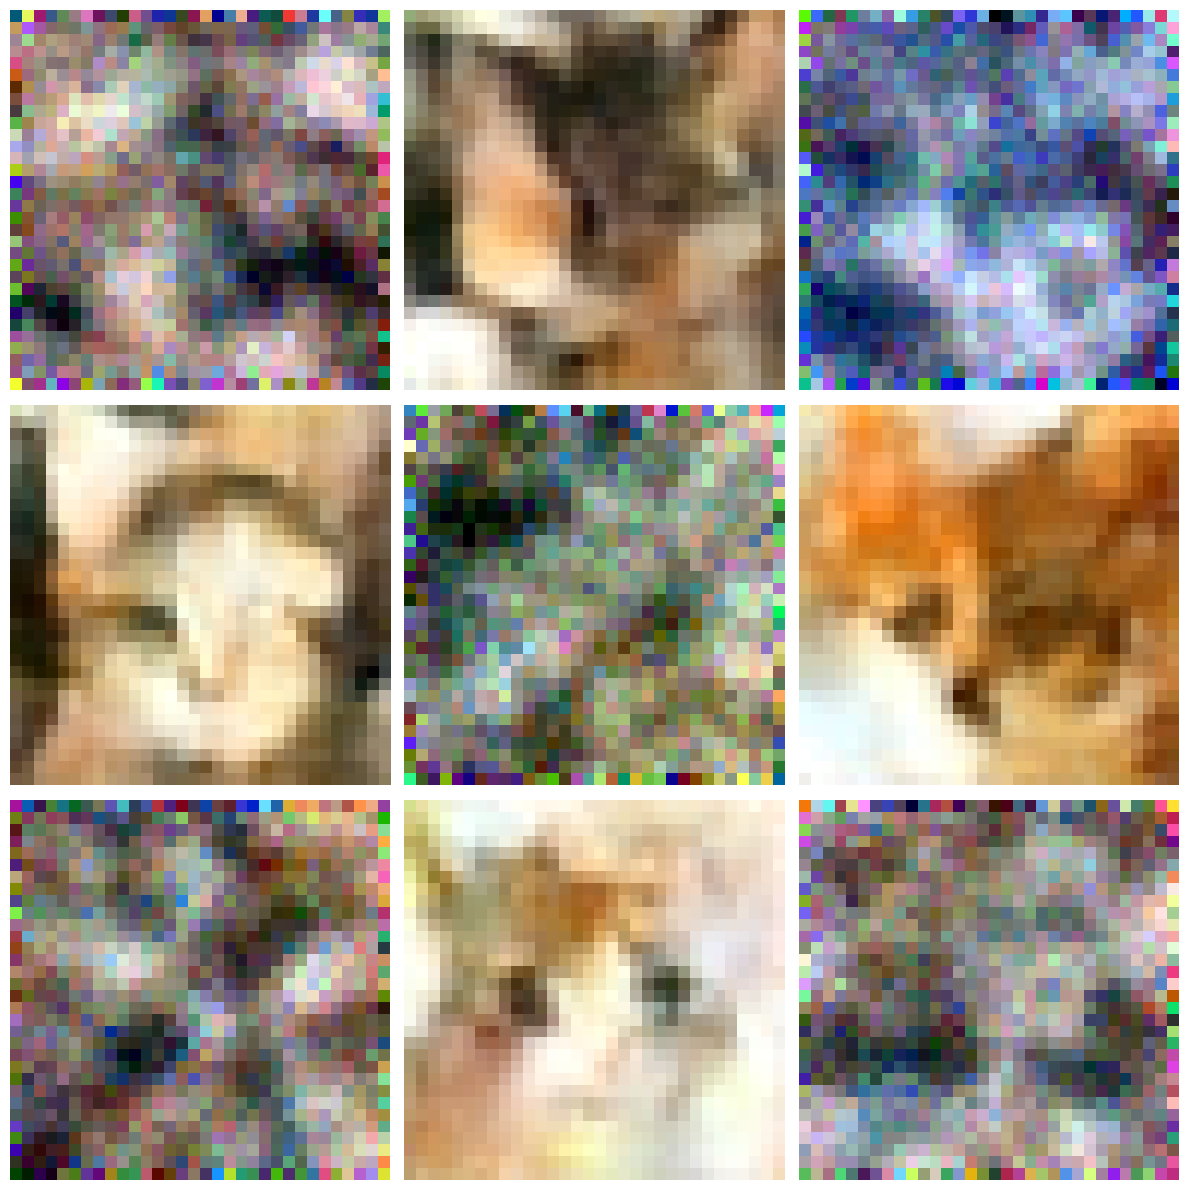

In [5]:
# Display generated samples
import matplotlib.pyplot as plt
from PIL import Image
import os

results_path = './test_run'  # Change to './test_run' for quick test results

# Get sample folders
sample_folders = sorted([d for d in os.listdir(results_path) 
                        if os.path.isdir(os.path.join(results_path, d)) and d.startswith('sample_ddpm_')])

if sample_folders:
    # Display 9 samples from the last checkpoint
    last_folder = os.path.join(results_path, sample_folders[-1])
    sample_images = sorted([f for f in os.listdir(last_folder) if f.endswith('.png')])[:9]
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    for idx, img_file in enumerate(sample_images):
        img = Image.open(os.path.join(last_folder, img_file))
        axes[idx].imshow(img)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# QUESTION 2:

In [12]:
# Part 2: Training with FID Computation (Fixed encoding)
import subprocess
import sys
import os
import time

os.environ['WANDB_MODE'] = 'disabled'

print("Starting Part 2 Training (1000 steps with FID)")
print("FID computation is SLOW - expect 15-60 minutes")
print("=" * 60)

start_time = time.time()

process = subprocess.Popen(
    [sys.executable, 'main.py',
     '--data_path', './data/train',
     '--data_class', 'cat',
     '--save_folder', './results_part2',
     '--time_steps', '1',
     '--train_steps', '100',
     '--image_size', '16',
     '--batch_size', '16',
     '--learning_rate', '1e-3',
     '--unet_dim', '16',
     '--save_and_sample_every', '10',
     '--fid'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1,
    encoding='utf-8',           # Added: explicit UTF-8 encoding
    errors='replace'            # Added: replace invalid characters
)

# Stream output line by line
for line in iter(process.stdout.readline, ''):
    if line:
        print(line, end='', flush=True)

return_code = process.wait()
elapsed_time = (time.time() - start_time) / 60

if return_code == 0:
    print("\n" + "=" * 60)
    print("Part 2 Training COMPLETE!")
    print(f"Total time: {elapsed_time:.1f} minutes")
else:
    print(f"\nTraining failed with error code: {return_code}")

Starting Part 2 Training (1000 steps with FID)
FID computation is SLOW - expect 15-60 minutes
Namespace(time_steps=1, train_steps=100, save_folder='./results_part2', data_path='./data/train', load_path=None, data_class='cat', image_size=16, batch_size=16, learning_rate=0.001, unet_dim=16, unet_dim_mults=[1, 2, 4, 8], fid=True, save_and_sample_every=10, visualize=False)
dataset length: 5065, dataset class: cat

loss: 0.6426:  10%|#         | 10/100 [00:03<00:28,  3.15it/s]compute FID between two folders
Found 1024 images in the folder results_part2\sample_ddpm_0


FID sample_ddpm_0 :   0%|          | 0/32 [00:00<?, ?it/s]

FID sample_ddpm_0 :   3%|▎         | 1/32 [00:00<00:11,  2.63it/s]

FID sample_ddpm_0 :   6%|▋         | 2/32 [00:02<00:43,  1.46s/it]

FID sample_ddpm_0 :   9%|▉         | 3/32 [00:02<00:27,  1.07it/s]

FID sample_ddpm_0 :  12%|█▎        | 4/32 [00:03<00:19,  1.46it/s]

FID sample_ddpm_0 :  16%|█▌        | 5/32 [00:03<00:15,  1.80it/s]

FID sample_ddpm_0 :  19%|█▉   

KeyboardInterrupt: 

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\--DPM-MAIN-DIR--\\windsurf_projects\\Variational-Autoencoder-and-Diffusion-Models-on-Animal-Faces-HQ-dataset__CVA_3\\A3_PartB\\A3_PartB\\results_part2\\part2_fid_plot.png'

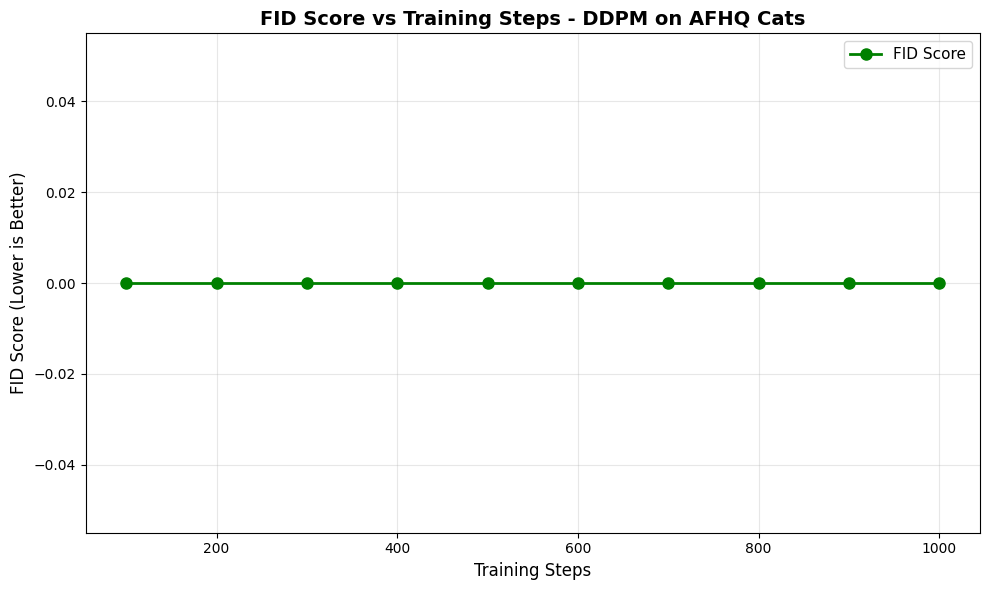

In [6]:
# Part 2: Create FID Plot
import matplotlib.pyplot as plt
import numpy as np

# TODO: Fill in FID values from training output
steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
fid_scores = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # Replace with actual values

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(steps, fid_scores, marker='o', linewidth=2, markersize=8, color='green', label='FID Score')
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('FID Score (Lower is Better)', fontsize=12)
plt.title('FID Score vs Training Steps - DDPM on AFHQ Cats', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()

# Save the plot
plt.savefig('./results_part2/part2_fid_plot.png', dpi=300, bbox_inches='tight')
print("✅ FID plot saved to: ./results_part2/part2_fid_plot.png")

# Display the plot
plt.show()

# Print statistics
print(f"\n📊 FID Statistics:")
print(f"   Initial FID (Step 100): {fid_scores[0]:.2f}")
print(f"   Final FID (Step 1000): {fid_scores[-1]:.2f}")
print(f"   Best FID: {min(fid_scores):.2f} (Step {steps[fid_scores.index(min(fid_scores))]})")
print(f"   FID Improvement: {fid_scores[0] - fid_scores[-1]:.2f}")

In [ ]:
# FULL SCALE TRAINING: Train the model (will take ~1-2 hours)
import subprocess
import sys
import os

os.environ['WANDB_MODE'] = 'disabled'

process = subprocess.Popen(
    [sys.executable, 'main.py',
     '--data_path', './data/train',
     '--save_folder', './results_afhq',
     '--time_steps', '50',
     '--train_steps', '10000',
     '--image_size', '32',
     '--batch_size', '32',
     '--learning_rate', '1e-3',
     '--unet_dim', '16',
     '--save_and_sample_every', '500'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1
)

for line in iter(process.stdout.readline, ''):
    if line:
        print(line, end='', flush=True)

if process.wait() == 0:
    print("\n✅ Training completed successfully!")

Namespace(time_steps=50, train_steps=10000, save_folder='./results_afhq', data_path='./data/train', load_path=None, data_class='cat', image_size=32, batch_size=32, learning_rate=0.001, unet_dim=16, unet_dim_mults=[1, 2, 4, 8], fid=False, save_and_sample_every=500, visualize=False)
dataset length: 5065, dataset class: cat


In [ ]:
# Visualize forward and backward diffusion
import subprocess
import sys
import os

os.environ['WANDB_MODE'] = 'disabled'

process = subprocess.Popen(
    [sys.executable, 'main.py',
     '--data_path', './data/train/',
     '--load_path', './results_afhq/model.pt',
     '--save_folder', './results_afhq',
     '--time_steps', '50',
     '--image_size', '32',
     '--batch_size', '32',
     '--learning_rate', '1e-3',
     '--unet_dim', '16',
     '--visualize'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1
)

for line in iter(process.stdout.readline, ''):
    if line:
        print(line, end='', flush=True)

if process.wait() == 0:
    print("\n✅ Visualization completed!")

Namespace(time_steps=50, train_steps=50000, save_folder='./results_afhq', data_path='./data/train/', load_path='./results_afhq/model.pt', data_class='cat', image_size=32, batch_size=32, learning_rate=0.001, unet_dim=16, unet_dim_mults=[1, 2, 4, 8], fid=False, save_and_sample_every=1000, visualize=True)
dataset length: 5065, dataset class: cat
Loading :  ./results_afhq/model.pt
âœ… Forward and backward diffusion images generated (wandb disabled)
   Forward diffusion: 5 images
   Backward diffusion: 5 images

✅ Visualization completed!


🖼️  Displaying Diffusion Visualization Results
Found 1 sample images



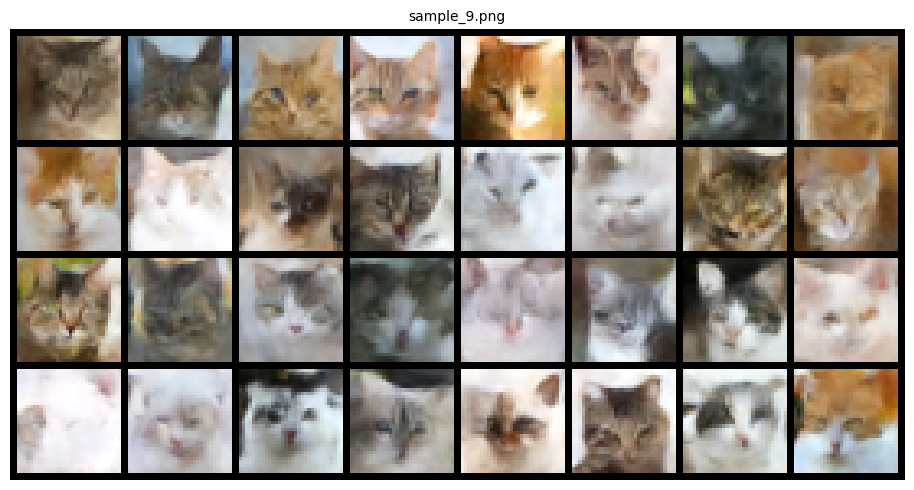


📁 Found 10 checkpoint folders:
   - sample_ddpm_0: 1024 images
   - sample_ddpm_1: 512 images
   - sample_ddpm_2: 512 images
   - sample_ddpm_3: 512 images
   - sample_ddpm_4: 512 images
   - sample_ddpm_5: 512 images
   - sample_ddpm_6: 512 images
   - sample_ddpm_7: 512 images
   - sample_ddpm_8: 512 images
   - sample_ddpm_9: 512 images

🎨 Displaying 9 samples from sample_ddpm_9 (final checkpoint):


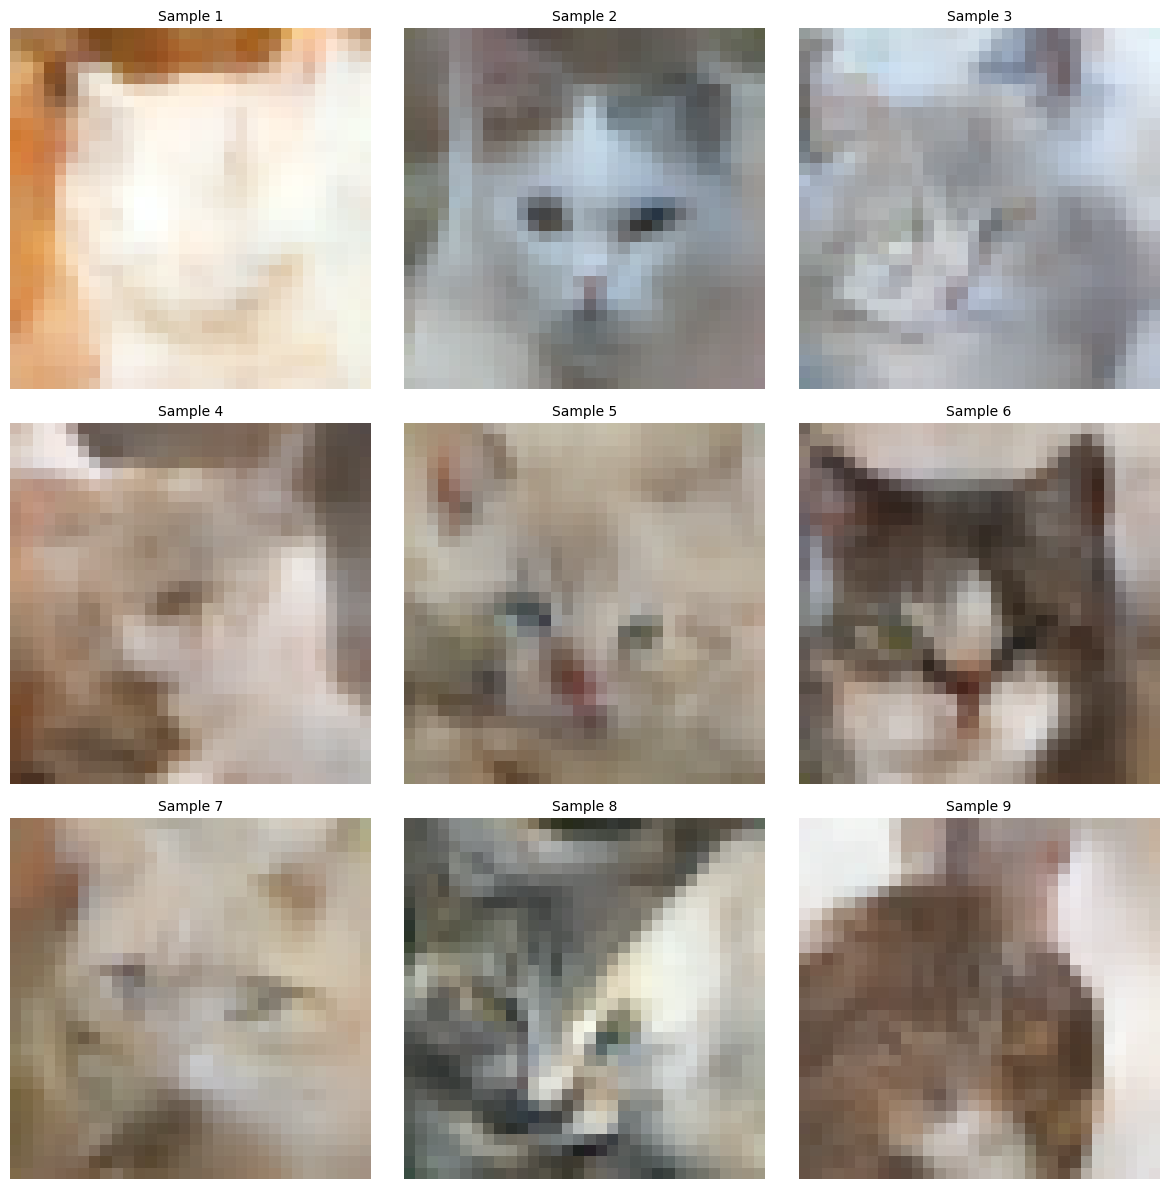

✅ Visualization complete!

The forward diffusion shows: clean image → progressively noisier
The backward diffusion shows: pure noise → progressively cleaner (denoising)


In [ ]:
# Display generated samples from trained model
import matplotlib.pyplot as plt
from PIL import Image
import os

results_path = './results_afhq'

# Get sample folders
sample_folders = sorted([d for d in os.listdir(results_path) 
                        if os.path.isdir(os.path.join(results_path, d)) and d.startswith('sample_ddpm_')])

if sample_folders:
    # Display 9 samples from the last checkpoint (best trained model)
    last_folder = os.path.join(results_path, sample_folders[-1])
    sample_images = sorted([f for f in os.listdir(last_folder) if f.endswith('.png')])[:9]
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    for idx, img_file in enumerate(sample_images):
        img = Image.open(os.path.join(last_folder, img_file))
        axes[idx].imshow(img)
        axes[idx].axis('off')
    
    plt.suptitle(f'Generated Cat Faces - {sample_folders[-1]}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize the forward and backward process
!python main.py --data_path ./data/train/ --load_path ./results_afhq/model.pt --save_folder ./results_afhq --time_steps 50 --train_steps 5000 --image_size 32 --batch_size 32 --learning_rate 1e-3 --unet_dim 16 --visualize

Namespace(time_steps=50, train_steps=5000, save_folder='./results_afhq', data_path='./data/train/', load_path='./results_afhq/model.pt', data_class='cat', image_size=32, batch_size=32, learning_rate=0.001, unet_dim=16, unet_dim_mults=[1, 2, 4, 8], fid=False, save_and_sample_every=1000, visualize=True)
dataset length: 5065, dataset class: cat
Loading :  ./results_afhq/model.pt
✅ Forward and backward diffusion images generated (wandb disabled)
   Forward diffusion: 5 images
   Backward diffusion: 5 images
